In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
tf.__version__

'2.16.1'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


Reading Data

In [6]:
PATH = os.getcwd()
data_dir = PATH + "/data"
print(data_dir)

/mnt/d/major/data


In [4]:
batch_size = 32
img_height = 528
img_width = 652

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 1600 files belonging to 8 classes.
Using 1280 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 1600 files belonging to 8 classes.
Using 320 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['Anwar Ratool', 'Chaunsa (Black)', 'Chaunsa (Summer Bahisht)', 'Chaunsa (White)', 'Dosehri', 'Fajri', 'Langra', 'Sindhri']


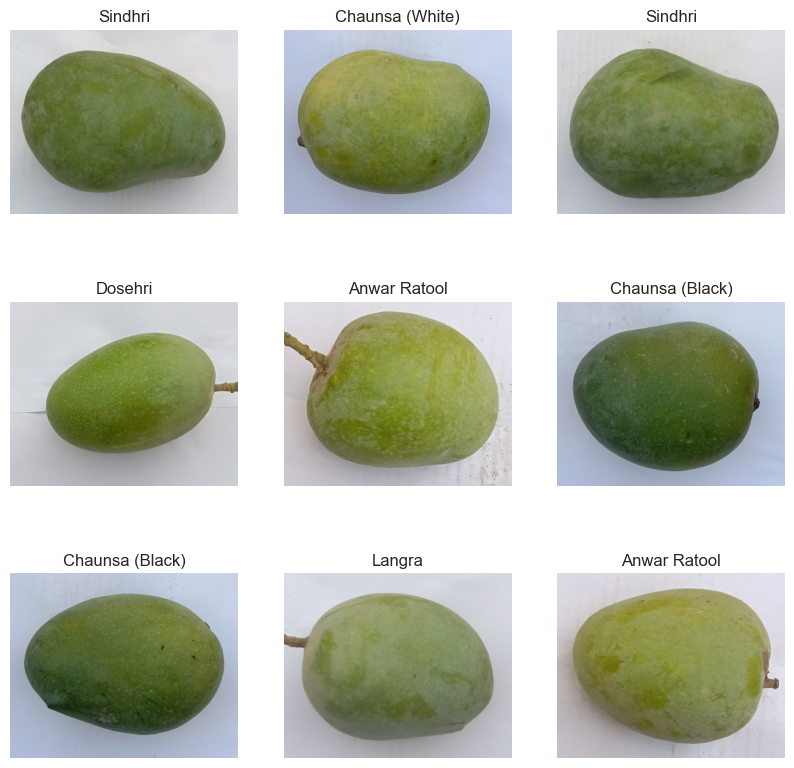

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        aax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')


In [21]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 528, 652, 3)
(32,)


In [22]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


Preprocessing Images

In [11]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    return image, label

In [25]:
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model Declaration

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [53]:
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
len(list(base_model.layers))

187

In [54]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8)

In [55]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [56]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [57]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [58]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [59]:
initial_epochs = 10

In [60]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.2131 - loss: 2.2121 - val_accuracy: 0.4844 - val_loss: 1.4852
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5329 - loss: 1.3595 - val_accuracy: 0.6797 - val_loss: 1.1081
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.6932 - loss: 0.9930 - val_accuracy: 0.7734 - val_loss: 0.8828
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7669 - loss: 0.7985 - val_accuracy: 0.7852 - val_loss: 0.7783
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8132 - loss: 0.6658 - val_accuracy: 0.8047 - val_loss: 0.7023
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8423 - loss: 0.5672 - val_accuracy: 0.8516 - val_loss: 0.6239
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8619 - loss: 0.5147 - val_accuracy: 0.8633 - val_loss: 0.5714
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8689 - loss: 0.4917 - val_accuracy: 0.8867 - 

Tuning Model

In [61]:
base_model.trainable = True

fine_tune_at = 180

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [62]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [63]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 317,128 (1.21 MB)

 Non-trainable params: 2,686,912 (10.25 MB)

In [64]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,)

Epoch 10/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.7110 - loss: 0.8735 - val_accuracy: 0.7930 - val_loss: 0.5818
Epoch 11/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9161 - loss: 0.3051 - val_accuracy: 0.7812 - val_loss: 0.5897
Epoch 12/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9303 - loss: 0.2395 - val_accuracy: 0.7852 - val_loss: 0.5585
Epoch 13/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9392 - loss: 0.2187 - val_accuracy: 0.8008 - val_loss: 0.5138
Epoch 14/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9451 - loss: 0.1982 - val_accuracy: 0.7969 - val_loss: 0.4784
Epoch 15/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9413 - loss: 0.2027 - val_accuracy: 0.8359 - val_loss: 0.4332
Epoch 16/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9496 - loss: 0.1710 - val_accuracy: 0.8438 - val_loss: 0.4184
Epoch 17/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9533 - loss: 0.1460 - val_accuracy: 

Predictions:
 [5 4 6 3 7 4 2 7 4 6 1 1 2 2 6 4 5 7 5 4 6 2 3 7 6 7 5 1 5 1 3 7]
Labels:
 [5 4 6 3 7 4 2 7 4 6 1 1 2 2 6 4 5 7 5 4 6 2 3 7 6 7 5 1 5 1 3 7]


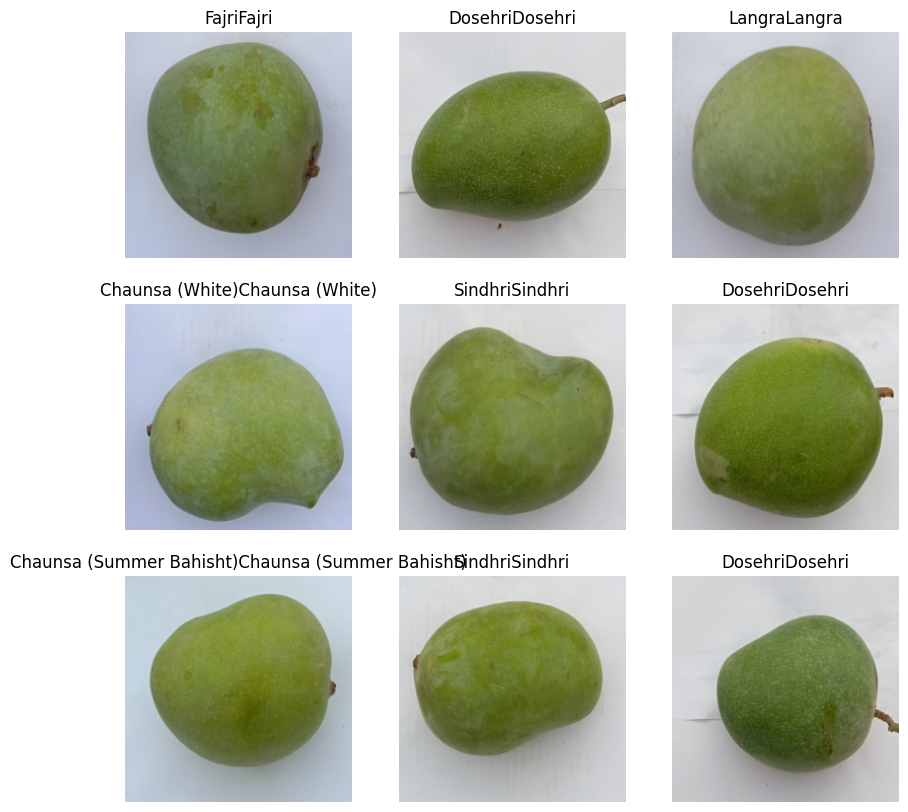

In [65]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


predictions = tf.nn.softmax(predictions, axis=-1)
predicted_classes = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_classes[i]] + class_names[label_batch[i]])
    plt.axis("off")

plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

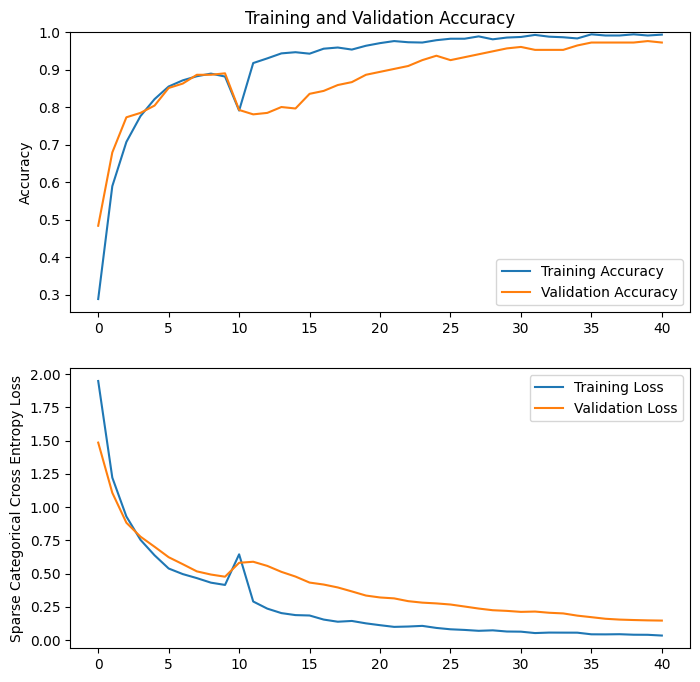

In [66]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(min(plt.ylim()), 1)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy Loss')
plt.ylim([[0, 1.0]])
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()

In [67]:
# Confusion Matrix
cm = tf.math.confusion_matrix(label_batch, predicted_classes)

In [68]:
cm

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 6]], dtype=int32)>

In [69]:
cm_np = cm.numpy()

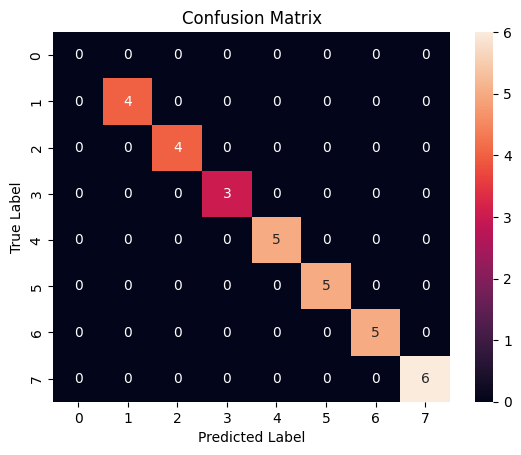

In [70]:
sns.heatmap(cm_np, annot=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

In [82]:
model.save(os.getcwd() + '/models/mnv3large.keras')

In [34]:
m2 = tf.keras.models.load_model(os.getcwd() + '/models/mnv3large.keras')
m2.layers[-2].trainable = False

In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_batches_test = 6
batch_size = 32

total_predictions = []
total_labels = []

for _ in range(num_batches_test):
    # noinspection PyUnresolvedReferences
    image_batch, label_batch = t_ds.as_numpy_iterator().next()
    predictions = m2.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(predictions, axis=-1)
    predicted_classes = tf.argmax(predictions, axis=-1)
    
    total_predictions.extend(predicted_classes.numpy().tolist())
    total_labels.extend(label_batch.tolist())


In [42]:
y_true = total_labels
y_pred = total_predictions

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [43]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.9583333333333334
Precision: 0.9606514923055872
Recall: 0.9583333333333334
F1: 0.9582754474740716
